# TME : EM et le geyser Old Faithful

Dans ce TME, l'objectif est de modéliser les éruptions du geyser Old Faithful. Il s'agit d'un geyser du parc national de Yellowstone.   
La durée des éruptions varie dans le temps ainsi que le délai entre deux éruptions consécutives. Le fichier 2015_tme4_faithful.txt recense des couples (durée de l'éruption, délai jusqu'à la prochaine éruption). C'est en utilisant ce fichier que nous allons définir un modèle des éruptions du geyser.

## Lecture des données

La fonction ci-dessous vous permettra de lire et de sauvegarder les données dans un tableau numpy à 2 dimensions : chaque ligne représente la durée d'une éruption ainsi que le délai jusqu'à la prochaine éruption, la première colonne du tableau contenant les durées et la deuxième les délais.

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
from math import *
from pylab import *
%matplotlib notebook

def read_file ( filename ):
    """
    Lit le fichier contenant les données du geyser Old Faithful
    """
    # lecture de l'en-tête
    infile = open ( filename, "r" )
    for ligne in infile:
        if ligne.find ( "eruptions waiting" ) != -1:
            break

    # ici, on a la liste des temps d'éruption et des délais d'irruptions
    data = []
    for ligne in infile:
        nb_ligne, eruption, waiting = [ float (x) for x in ligne.split () ]
        data.append ( eruption )
        data.append ( waiting )
    infile.close ()

    # transformation de la liste en tableau 2D
    data = np.asarray ( data )
    data.shape = ( int ( data.size / 2 ), 2 )

    return data

data = read_file ( "2015_tme4_faithful.txt" )

## Loi normale
Vous l'avez compris, chaque donnée xi de notre échantillon est en fait un couple, que nous noterons xi = (xi,zi). Nous allons représenter la distribution de ces couples par des lois normales bidimensionnelles.  
Ecrivez une fonction qui, étant donné deux nombres réels x et z, ainsi que d'un quintuplet (μx,μz,σx,σz,ρ), renvoie la valeur de la fonction de densité f(x,z). 

In [2]:
def normale_bidim(x,z,param):
    if len(param) != 5:
        print('panic')
        return
    #application directe de la formule
    return ((1.0/(math.pi*2*param[2]*param[3]*math.sqrt(1.0-param[4]**2)))
    *math.exp((-1.0/(2*(1-param[4]**2)))*((((x-param[0])/param[2])**2)-2*param[4]*(((x-param[0])*(z-param[1]))/(param[2]*param[3]))+(((z-param[1])/param[3])**2))))

In [3]:
normale_bidim(1,2,(1.0,2.0,3.0,4.0,0))

0.013262911924324612

In [4]:
normale_bidim(1,0,(1.0,2.0,1.0,2.0,0.7))

0.0418047994276145

Afin de bien comprendre la signification des paramètres σx,σz,ρ, vous allez dessiner des isocontours de cette fonction de densité en utilisant la fonction ci-dessous. Le paramètre params attendu est un quintuplet (μx,μz,σx,σz,ρ). 

In [5]:
import matplotlib.pyplot as plt

def dessine_1_normale ( params ):
    # récupération des paramètres
    mu_x, mu_z, sigma_x, sigma_z, rho = params

    # on détermine les coordonnées des coins de la figure
    x_min = mu_x - 2 * sigma_x
    x_max = mu_x + 2 * sigma_x
    z_min = mu_z - 2 * sigma_z
    z_max = mu_z + 2 * sigma_z

    # création de la grille
    x = np.linspace ( x_min, x_max, 100 )
    z = np.linspace ( z_min, z_max, 100 )
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm = X.copy ()
    for i in range ( x.shape[0] ):
        for j in range ( z.shape[0] ):
            norm[i,j] = normale_bidim ( x[i], z[j], params )

    # affichage
    fig = plt.figure ()
    plt.contour ( X, Z, norm, cmap=cm.autumn )
    plt.show ()

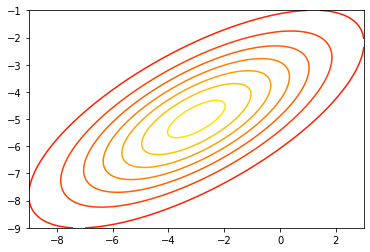

In [6]:
dessine_1_normale((-3.0,-5.0,3.0,2.0,0.7))

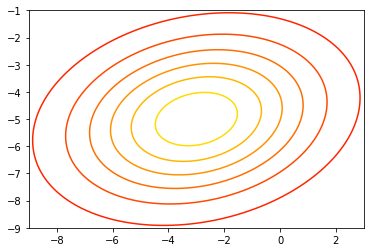

In [7]:
dessine_1_normale((-3.0,-5.0,3.0,2.0,0.2))

ρ, compris entre -1 et 1, délimite les catégories (concentriques) où l'on étudie la dispersion des variables. 

## Visualisation des données

Nous allons modéliser les éruptions du geyser Old Faithful grâce à une mixture de deux lois normales bidimensionnelles. Afin de comprendre pourquoi nous avons choisi ce modèle, visualisez les données en question utilisant le script ci-dessous.  
La fonction `dessine_normales` prend en argument le tableau `data` des données que vous avez lues à la question 1, un tableau `params` contenant les quintuplets des deux lois normales, un tableau `weights` de 2 éléments correspondant aux poids des lois normales, un tableau `bounds` définissant les coordonnées des coins de la figure (ce tableau est calculé par la fonction `find_bounds`). Enfin, le dernier paramètre, `ax`, sert à stocker le résultat de l'affichage. Il vous servira quand vous créerez une vidéo illustrant l'exécution de votre algorithme EM. 

C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


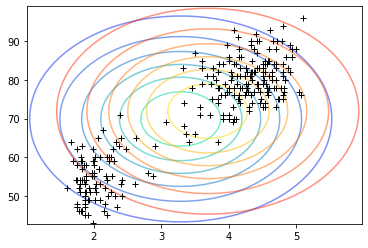

In [8]:
def dessine_normales(data, params, weights, bounds, ax):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # on détermine les coordonnées des coins de la figure
    x_min = bounds[0]
    x_max = bounds[1]
    z_min = bounds[2]
    z_max = bounds[3]

    # création de la grille
    nb_x = nb_z = 100
    x = np.linspace(x_min, x_max, nb_x)
    z = np.linspace(z_min, z_max, nb_z)
    X, Z = np.meshgrid(x, z)

    # calcul des normales
    norm0 = np.zeros((nb_x,nb_z))
    for j in range (nb_z):
        for i in range (nb_x):
            norm0[j,i] = normale_bidim(x[i], z[j], params[0])# * weights[0]
    norm1 = np.zeros((nb_x,nb_z))
    for j in range (nb_z):
        for i in range (nb_x):
             norm1[j,i] = normale_bidim(x[i], z[j], params[1])# * weights[1]

    # affichages des normales et des points du dataset
    ax.contour(X, Z, norm0, cmap=cm.winter, alpha=0.5)
    ax.contour(X, Z, norm1, cmap=cm.autumn, alpha=0.5)
    for point in data:
        ax.plot ( point[0], point[1], 'k+' )


def find_bounds ( data, params ):
    # récupération des paramètres
    mu_x0, mu_z0, sigma_x0, sigma_z0, rho0 = params[0]
    mu_x1, mu_z1, sigma_x1, sigma_z1, rho1 = params[1]

    # calcul des coins
    x_min = min(mu_x0-2*sigma_x0, mu_x1-2*sigma_x1, data[:,0].min())
    x_max = max(mu_x0+2*sigma_x0, mu_x1+2*sigma_x1, data[:,0].max())
    z_min = min(mu_z0-2*sigma_z0, mu_z1-2*sigma_z1, data[:,1].min())
    z_max = max(mu_z0+2*sigma_z0, mu_z1+2*sigma_z1, data[:,1].max())

    return (x_min, x_max, z_min, z_max)


# affichage des données : calcul des moyennes et variances des 2 colonnes
mean1 = data[:,0].mean()
mean2 = data[:,1].mean()
std1  = data[:,0].std()
std2  = data[:,1].std()

# les paramètres des 2 normales sont autour de ces moyennes
params = np.array([(mean1 - 0.2, mean2 - 1, std1, std2, 0),
                     (mean1 + 0.2, mean2 + 1, std1, std2, 0)])
weights = np.array([0.4, 0.6])
bounds = find_bounds(data, params)

# affichage de la figure
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
dessine_normales(data, params, weights, bounds, ax1)
fig1.show()

# Il est logique d'obtenir le schéma suivant, puisqu'EM n'a pas encore été lancé.
# Le dessin des ellipses représente l'état initial de l'algorithme.
# Le schéma donné comme 'corrigé' présuppose, à tort,
# que les deux clusters de points ont déjà été précisément déterminés

## Algorithme EM

Comme vu en cours, soit Y une variable aléatoire indiquant quelle classe/loi normale bidimensionnelle a généré le couple de données (x,z): Y=y0 indique que le couple (x,z) a été généré par la première loi normale bidimensionnelle tandis que Y=y0 indique que le couple (x,z) a été généré par la seconde.  

### Phase 1

Nous allons maintenant écrire l'étape E de l'algorithme EM, qui va nous permettre d'estimer les paramètres de la mixture de lois normales bidimensionnelles. Vous trouverez quelque chose de très détaillé sur 
http://mapsi.lip6.fr/pmwiki.php?n=Cours.TME4, section 5

In [9]:
def Q_i(data, current_params, current_weights):
    # Q aura autant de lignes que les données, et une colonne par possibilité de loi
    Q = np.zeros((len(data),2))
    for i in range(len(data)):
        # application des formules
        a0 = current_weights[0] * normale_bidim(data[i,0], data[i,1], current_params[0])
        a1 = current_weights[1] * normale_bidim(data[i,0], data[i,1], current_params[1])
        Q[i,0] = a0/(a0 + a1) # à quel point ai-je le droit de m'attendre à ce que i suive la loi 0 ?
        Q[i,1] = a1/(a0 + a1) # à quel point ai-je le droit de m'attendre à ce que i suive la loi 0 ?
    return Q

# Q est une espérance

In [10]:
#current_params = np.array ([(mu_x, mu_z, sigma_x, sigma_z, rho),   # params 1ère loi normale
#                             (mu_x, mu_z, sigma_x, sigma_z, rho)]) # params 2ème loi normale
current_params = np.array([[3.28778309, 69.89705882, 1.13927121, 13.56996002, 0.],
                           [3.68778309, 71.89705882, 1.13927121, 13.56996002, 0.]])
# current_weights = np.array ([pi_0, pi_1])
current_weights = np.array ([0.5, 0.5])
T = Q_i (data, current_params, current_weights)
print(T)

# test validé

[[0.46939088 0.53060912]
 [0.66899936 0.33100064]
 [0.50349992 0.49650008]
 [0.61489199 0.38510801]
 [0.38336517 0.61663483]
 [0.58880846 0.41119154]
 [0.36370054 0.63629946]
 [0.45319835 0.54680165]
 [0.66597113 0.33402887]
 [0.39678193 0.60321807]
 [0.66674347 0.33325653]
 [0.43178097 0.56821903]
 [0.42637974 0.57362026]
 [0.68892521 0.31107479]
 [0.37635861 0.62364139]
 [0.6484613  0.3515387 ]
 [0.65298434 0.34701566]
 [0.36662753 0.63337247]
 [0.68719135 0.31280865]
 [0.41996736 0.58003264]
 [0.67617442 0.32382558]
 [0.68892521 0.31107479]
 [0.48363046 0.51636954]
 [0.53749981 0.46250019]
 [0.41197248 0.58802752]
 [0.45858658 0.54141342]
 [0.65505529 0.34494471]
 [0.44056782 0.55943218]
 [0.45294617 0.54705383]
 [0.40629466 0.59370534]
 [0.43213395 0.56786605]
 [0.40900976 0.59099024]
 [0.52258721 0.47741279]
 [0.43366997 0.56633003]
 [0.46503453 0.53496547]
 [0.65892553 0.34107447]
 [0.67878225 0.32121775]
 [0.37438794 0.62561206]
 [0.65456976 0.34543024]
 [0.35282612 0.64717388]


In [11]:
current_params = np.array([[3.2194684, 67.83748075, 1.16527301, 13.9245876,  0.9070348],
                           [3.75499261, 73.9440348, 1.04650191, 12.48307362, 0.88083712]])
current_weights = np.array ([0.49896815, 0.50103185])
T = Q_i(data, current_params, current_weights)
print(T)

# test validé

[[0.44352868 0.55647132]
 [0.70465534 0.29534466]
 [0.47692866 0.52307134]
 [0.61531052 0.38468948]
 [0.38502072 0.61497928]
 [0.58493721 0.41506279]
 [0.37621272 0.62378728]
 [0.42185109 0.57814891]
 [0.70665534 0.29334466]
 [0.39346396 0.60653604]
 [0.70167538 0.29832462]
 [0.41383928 0.58616072]
 [0.40975898 0.59024102]
 [0.74656919 0.25343081]
 [0.37669861 0.62330139]
 [0.67922662 0.32077338]
 [0.65636463 0.34363537]
 [0.37135623 0.62864377]
 [0.73399065 0.26600935]
 [0.40550488 0.59449512]
 [0.7213767  0.2786233 ]
 [0.74656919 0.25343081]
 [0.45501587 0.54498413]
 [0.51582119 0.48417881]
 [0.38523308 0.61476692]
 [0.42949663 0.57050337]
 [0.6836669  0.3163331 ]
 [0.42010952 0.57989048]
 [0.43210955 0.56789045]
 [0.39352601 0.60647399]
 [0.4049539  0.5950461 ]
 [0.3914101  0.6085899 ]
 [0.49984226 0.50015774]
 [0.41723141 0.58276859]
 [0.4416097  0.5583903 ]
 [0.69482148 0.30517852]
 [0.72988155 0.27011845]
 [0.3666247  0.6333753 ]
 [0.67090708 0.32909292]
 [0.37243493 0.62756507]


### Phase 2

Ecrivez maintenant l'étape M de l'algorithme EM, c'est-à-dire l'étape dans laquelle on met à jour les quintuplets de paramètres. 

In [12]:
def M_step(data,T,current_params,current_weights):
    new_params = np.zeros((2,5))
    new_weights = np.zeros(2)
    
    #calcul des poids
    new_weights[0] = T[:,0].sum()/(T[:,0].sum()+T[:,1].sum())
    new_weights[1] = T[:,1].sum()/(T[:,0].sum()+T[:,1].sum())
    
    #calcul de mux0 et mux1
    for i in range(len(data)):
        new_params[0,0] += T[i,0]*data[i,0]
        new_params[1,0] += T[i,1]*data[i,0]
    new_params[0,0] /= T[:,0].sum()
    new_params[1,0] /= T[:,1].sum()
    
    #calcul de muz0 et muz1
    for i in range(len(data)):
        new_params[0,1] += T[i,0]*data[i,1]
        new_params[1,1] += T[i,1]*data[i,1]
    new_params[0,1] /= T[:,0].sum()
    new_params[1,1] /= T[:,1].sum()
    
    #calcul de sigx0 et sigx1
    for i in range(len(data)):
        new_params[0,2] += T[i,0]*(data[i,0]-new_params[0,0])**2
        new_params[1,2] += T[i,1]*(data[i,0]-new_params[1,0])**2
    new_params[0,2] /= T[:,0].sum()
    new_params[0,2] = math.sqrt(new_params[0,2])
    new_params[1,2] /= T[:,1].sum()
    new_params[1,2] = math.sqrt(new_params[1,2])
    
    #calcul de sigz0 et sigz1
    for i in range(len(data)):
        new_params[0,3] += T[i,0]*(data[i,1]-new_params[0,1])**2
        new_params[1,3] += T[i,1]*(data[i,1]-new_params[1,1])**2
    new_params[0,3] /= T[:,0].sum()
    new_params[0,3] = math.sqrt(new_params[0,3])
    new_params[1,3] /= T[:,1].sum()
    new_params[1,3] = math.sqrt(new_params[1,3])
    
    #calcul de rho0 et rho1
    for i in range(len(data)):
        new_params[0,4] += T[i,0]*(((data[i,0]-new_params[0,0])*(data[i,1]-new_params[0,1]))/(new_params[0,2]*new_params[0,3]))
        new_params[1,4] += T[i,1]*(((data[i,0]-new_params[1,0])*(data[i,1]-new_params[1,1]))/(new_params[1,2]*new_params[1,3]))
    new_params[0,4] /= T[:,0].sum()
    new_params[1,4] /= T[:,1].sum()
    
    return new_params,new_weights

In [13]:
current_params = array([(2.51460515, 60.12832316, 0.90428702, 11.66108819, 0.86533355),
                        (4.2893485,  79.76680985, 0.52047055,  7.04450242, 0.58358284)])
current_weights = array([0.45165145,  0.54834855])
Q = Q_i(data, current_params, current_weights)
M_step(data, Q, current_params, current_weights)

# test validé

(array([[ 2.33418412, 58.06784269,  0.74224878, 10.17591317,  0.82161824],
        [ 4.33880698, 80.36132657,  0.37819574,  5.71033527,  0.3008745 ]]),
 array([0.42453067, 0.57546933]))

### Mise au point

Aligner le tout pour créer l'algorithme EM :

In [14]:
def EM(data):
    %matplotlib inline
    # initialisation avec les valeurs données
    mean1 = data[:,0].mean()
    mean2 = data[:,1].mean()
    std1 = data[:,0].std()
    std2 = data[:,1].std()
    params = np.array ([(mean1-0.2, mean2-1, std1, std2, 0),
                     (mean1+0.2, mean2+1, std1, std2, 0)])
    weights = np.array([0.5, 0.5])
    
    # affichage préalable de la situation
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dessine_normales(data, params, weights, bounds, ax)
    fig.show()

    for i in range(20):
        # itération des calculs de Q_i_t+1 et de sa maximisation
        params, weights = M_step(data, Q_i(data, params, weights), params, weights)
        # affichage à chaque pas
        fig = plt.figure()
        ax = fig.add_subplot(111)
        dessine_normales(data, params, weights, bounds, ax)
        fig.show()
        
# Le choix de faire vingt pas au lieu de quatre comme requis 
# permet de s'assurer que la vidéo doit fonctionner.
# L'algorithme évolue comme il faut au cours du temps.
# Les clusters finissent par se stabiliser au bout d'une quinzaine d'itérations.

C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


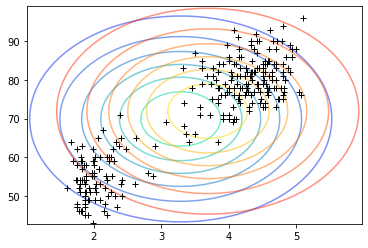

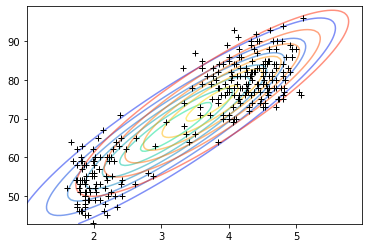

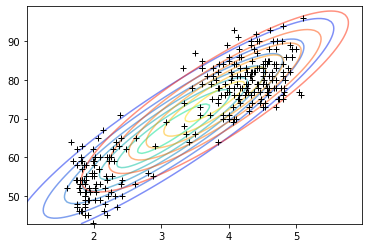

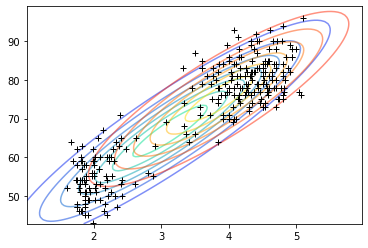

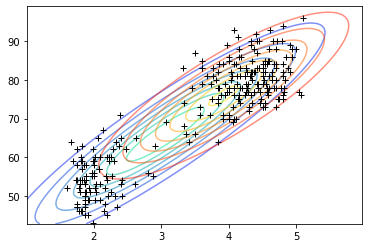

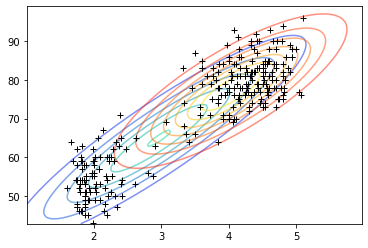

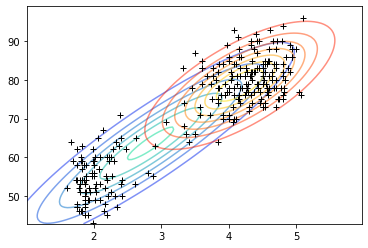

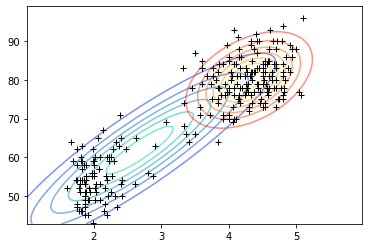

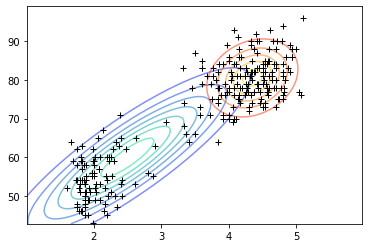

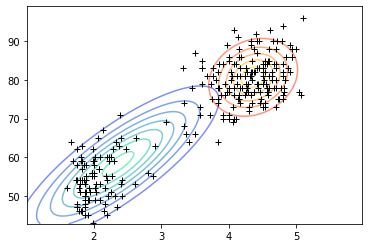

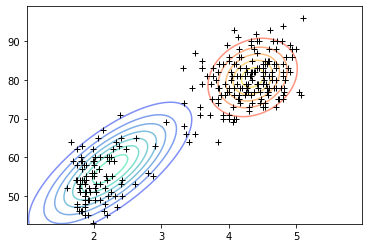

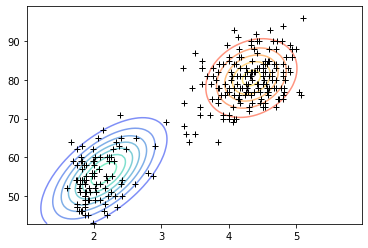

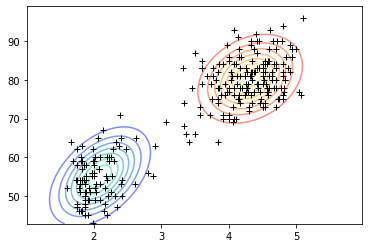

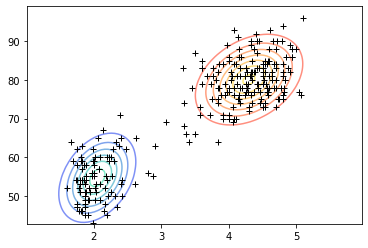

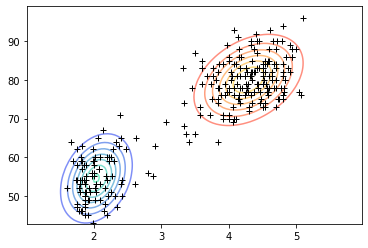

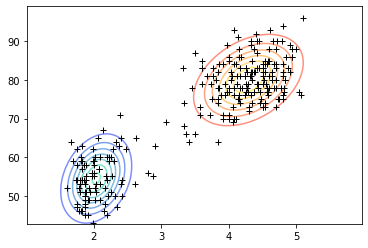

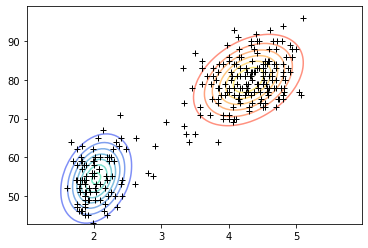

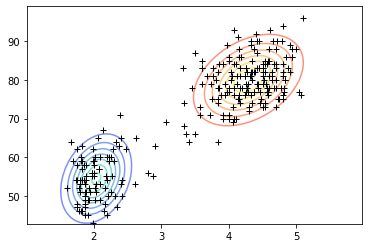

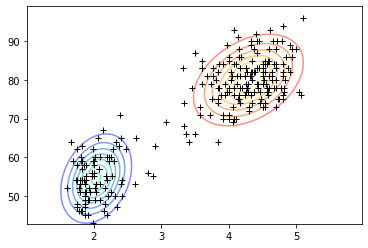

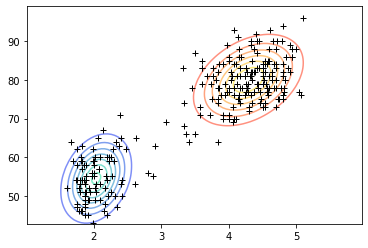

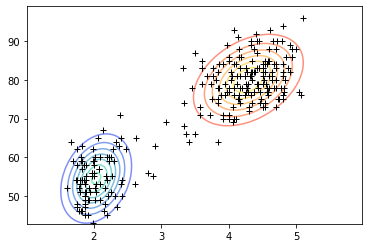

In [15]:
EM(data)

## Animation -- optionnelle

In [16]:
def reEM(data):
    # EM, version stockage
    mean1 = data[:,0].mean()
    mean2 = data[:,1].mean()
    std1 = data[:,0].std()
    std2 = data[:,1].std()
    params = np.array ([(mean1-0.2, mean2-1, std1, std2, 0),
                     (mean1+0.2, mean2+1, std1, std2, 0)])
    weights = np.array([0.5, 0.5])
    
    results = []
    for i in range(20):
        Q = Q_i(data, params, weights)
        # mise à jour des paramètres et poids à chaque itération
        params, weights = M_step(data, Q, params, weights)
        # ajout au vecteur des résultats
        results.append((params, weights))
    return results

In [17]:
res_EM = reEM(data)

In [ ]:
%matplotlib notebook

# calcul des bornes pour contenir toutes les lois normales calculées
def find_video_bounds(data, res_EM):
    bounds = np.asarray(find_bounds(data, res_EM[0][0]))
    for param in res_EM:
        new_bound = find_bounds(data, param[0])
        for i in [0,2]:
            bounds[i] = min(bounds[i], new_bound[i])
        for i in [1,3]:
            bounds[i] = max(bounds[i], new_bound[i])
    return bounds

bounds = find_video_bounds(data, res_EM)

import matplotlib.animation as animation
# création de l'animation : tout d'abord on crée la figure qui sera animée
fig2 = plt.figure()
ax2 = fig2.gca(xlim=(bounds[0], bounds[1]), ylim=(bounds[2], bounds[3]))

# la fonction appelée à chaque pas de temps pour créer l'animation
def animate(i):
    ax2.cla()
    dessine_normales(data, res_EM[i][0], res_EM[i][1], bounds, ax2)
    ax2.text(5, 40, 'step = ' + str(i))
    print("step animate = %d" % (i))

# exécution de l'animation
anim = animation.FuncAnimation(fig2, animate, frames = len(res_EM), interval=200)
plt.show()

# éventuellement, sauver l'animation dans une vidéo
anim.save('old_faithful.avi', bitrate=4000)

# Fonctionne.
# (parfois impossible de jouer la vidéo selon l'environnement ; la retrouver en pièce jointe)